In [1]:
%load_ext autoreload
%autoreload 2

### test EY analysis at one location

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvcircuit as pvc
import ipywidgets as widgets
%matplotlib widget

Tandems version 0.989
Data path is:  /Users/jgeisz/opt/anaconda3/envs/pvdev/lib/python3.9/site-packages/tandems/data/


In [3]:
#import EQE of WB417
path = pvc.datapath
file = 'WB417n6_C_EQE.csv'
df2J = pd.read_csv(path+file, index_col=0)
WB417_EQE = df2J.to_numpy(dtype=np.float64, copy=True) #numpy.ndarray
WB417_xEQE = df2J.index.to_numpy(dtype=np.float64, copy=True) #numpy.ndarray
EQE2J = pvc.EQE(WB417_EQE, WB417_xEQE, 'WB417_EQE')  #EQE class
EQE2J.sjuncs = ['GaInP','GaAs']  #rename junctions

#import TMY data of Boulder
Boulder = pvc.TMY(497)

#models of WB417
dev3T = pvc.Tandem3T()
dev3T.set(name='WB417dev3T', Rz = 2.3)
dev3T.top.set(Eg=1.87, J0ratio=[ 80., 22.], Jext=0.0131, Gsh=1e-8)   
dev3T.bot.set(Eg=1.419, J0ratio=[10., 15.], Jext=0.0128, Gsh= 5e-5)
dev3T.bot.set(Rser=0.2, beta=5, area=0.89)
dev2T = pvc.Multi2T.copy3T(dev3T)

In [16]:
ui, ax, rax = EQE2J.controls(Pspec='global')
ui

In [7]:
Boulder = pvc.TMY(497)
Boulder.name

'40.13_-105.22_1616_-7_axis'

In [8]:
Boulder.cellbandgaps(EQE2J, 25)
Boulder.cellcurrents(EQE2J, STC=True)
Boulder.cellcurrents(EQE2J)
print(Boulder.JscSTCs, Boulder.RefPower, Boulder.YearlyEnergy)

[[0.016 0.014]
 [0.013 0.013]
 [0.011 0.012]] [1348.043 1000.471  900.187] 2082.870057087224


In [9]:
#cfglist = ['VM11','VM43','VM32','VM21','VM31','VM41','MPP','CM']
iref = 1 #global
ncells = 60
model = dev3T   #pointer?

operlist = pvc.EY.VMlist(9)
num = len(operlist)
ratio = [0] * num
sEY = [0] * num
rEY = [0] * num
sEYeff = [0] * num
rEYeff = [0] * num
sSTCeff = [0] * num
rSTCeff = [0] * num
sloss = [0] * num
rloss = [0] * num

for i, oper in enumerate(operlist):
    model.bot.set(pn=1) #s-type 
    bot, top, ratio[i], type3T= pvc.EY.cellmodeldesc(model,oper)
    sloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
    sSTCeff[i] = Boulder.cellSTCeff(model,oper)
    sEY[i], sEYeff[i] = Boulder.cellEYeff(model,oper)
    
    model.bot.set(pn=-1) #r-type 
    bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model,oper)
    rloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
    rSTCeff[i] = Boulder.cellSTCeff(model,oper)
    rEY[i], rEYeff[i] = Boulder.cellEYeff(model,oper)    

In [10]:
df = pd.DataFrame()
df['operlist'] = operlist
df['ratio'] = ratio
df['sEY'] = sEY
df['rEY'] = rEY
df['sEYeff'] = sEYeff
df['rEYeff'] = rEYeff
df['sSTCeff'] = sSTCeff
df['rSTCeff'] = rSTCeff
df['sloss'] = sloss
df['rloss'] = rloss

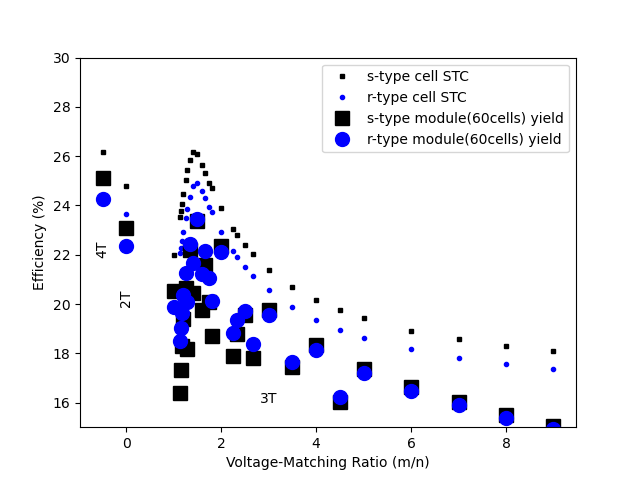

In [11]:
fig, ax = plt.subplots()
ax.plot(df['ratio'], 100*df['sSTCeff'], c='black', ms=3, lw=0, marker='s', label='s-type cell STC')
ax.plot(df['ratio'], 100*df['rSTCeff'], c='blue', ms=3, lw=0, marker='o', label='r-type cell STC')
ax.plot(df['ratio'], 100*df['sEYeff']*df['sloss'], c='black', ms=10, lw=0, marker='s', label='s-type module(60cells) yield')
ax.plot(df['ratio'], 100*df['rEYeff']*df['rloss'], c='blue', ms=10, lw=0, marker='o', label='r-type module(60cells) yield')
ax.set_ylim(15,30)
ax.set_ylabel('Efficiency (%)')
ax.set_xlabel('Voltage-Matching Ratio (m/n)')
ax.text(3,16,'3T', ha='center')
ax.text(0,20,'2T', ha='center', rotation='vertical')
ax.text(-0.5,22,'4T', ha='center', rotation='vertical')
ax.legend()